In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import trigauss
import mesh
import fem

In [2]:
pts, tris, boundaries = mesh.load_mesh('cylflow.msh')
pts = pts[:,:2]

A,B,D1,D2 = fem.assemble_p1p1(pts, tris)

In [3]:
from functools import reduce
def union_many(boundaries):
    return reduce(np.union1d, boundaries)

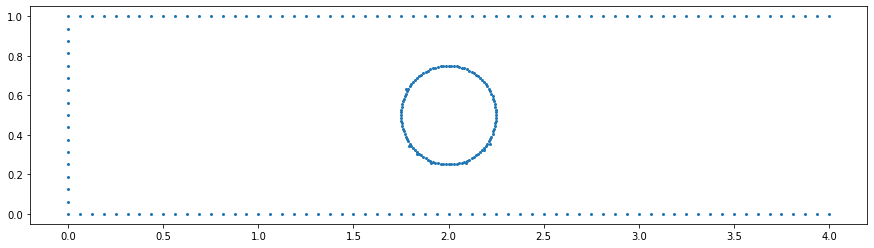

In [7]:
#boundaries[0] = circle
#boundaries[1] = left inlet
#boundaries[2] = bottom wall
#boundaries[3] = right wall
#boundaries[4] = top wall

def boundary_nodes(xy):
    x,y=xy
    if x==0:
        return True
    if y==1:
        return True
    if y==0:
        return True
    if np.sqrt((x-2)**2+(y-0.5)**2) < 0.26:
        return True
    return False

def boundary_nodes_pressure(xy):
    x,y=xy
    if y==1:
        return False
    if y==0:
        return False
    if x==4:
        return True
    return False

dc_nodes = []
for i,q in enumerate(pts):
    if boundary_nodes(q):
        dc_nodes.append(i)
dc_nodes = np.array(dc_nodes)

R = fem.create_restriction(A.shape[0], dc_nodes)
plt.figure(figsize=(15,4))
plt.plot(pts[dc_nodes][:,0], pts[dc_nodes][:,1], 'o', markersize=2)

In [9]:
def boundary_u_x(xy):
    x, y = xy
    if y==1 or y==0 or (x-2)**2 + (y-0.5)**2 <= 0.3**2:
        return 0
    elif x==0:
        return 1

def boundary_u_y(xy):
    return 0

def create_rhs(A, pts, boundary_nodes, boundary_function):
    boundary_values = np.apply_along_axis(boundary_function, 1, pts[boundary_nodes])
    rhs = np.zeros(A.shape[0])
    bcs = np.zeros(A.shape[0])
    Acsc = A.tocsc()
    
    for i, bc in enumerate(boundary_nodes):
        col = np.array(Acsc[:,bc].todense()).flatten()
        rhs -= col * boundary_values[i]
        bcs[bc] = boundary_values[i]
    
    return rhs, bcs

rhs_x, bcs_x = create_rhs(A, pts, dc_nodes, boundary_u_x)
rhs_y, bcs_y = create_rhs(A, pts, dc_nodes, boundary_u_y)

In [11]:
import scipy.interpolate as si
import matplotlib.colors as colors

def plot_soln(points, triangles, u):
    plt.tripcolor(points[:,0], points[:,1], triangles, u, shading='gouraud')

In [12]:
Ah = R.T@A@R

Dx = D1@R
Dy = D2@R
Zh = None
Saddle = sp.bmat([
    [Ah,   Zh, -Dx.T],
    [Zh,   Ah, -Dy.T],
    [-Dx, -Dy,    Zh]
]).tocsr()

In [13]:
Ah.shape

(1861, 1861)

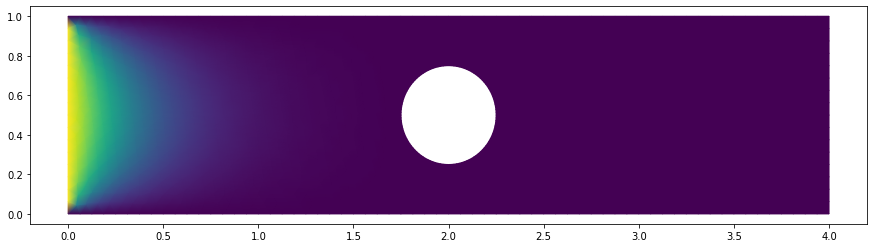

In [16]:
u_x = spla.cg(Ah, R.T@rhs_x)[0]
plt.figure(figsize=(15,4))
plot_soln(pts, tris, R@u_x + bcs_x)

In [17]:
rhs_p = D1@bcs_x + D2@bcs_y
up = spla.cg(Saddle, np.hstack([R.T@rhs_x, R.T@rhs_y, rhs_p]))[0]

g = -rhs_p
D = sp.bmat([[Dx.T],[Dy.T]])

pressure_size = Dx.shape[0]
velocity_size_1d = Ah.shape[0]
velocity_size_2d = 2*velocity_size_1d

def schur_matvec(q):
    A = sp.block_diag([Ah,Ah])
    q_hat = D@q
    q_hh = spla.spsolve(A, q_hat)
    return D.T@q_hh

In [18]:
s = (R.T@rhs_x).shape[0]
u_x = R@up[:s] + bcs_x
u_y = R@up[s:2*s] + bcs_y
p = up[2*s:]

Text(0.5, 1.0, 'Pressure')

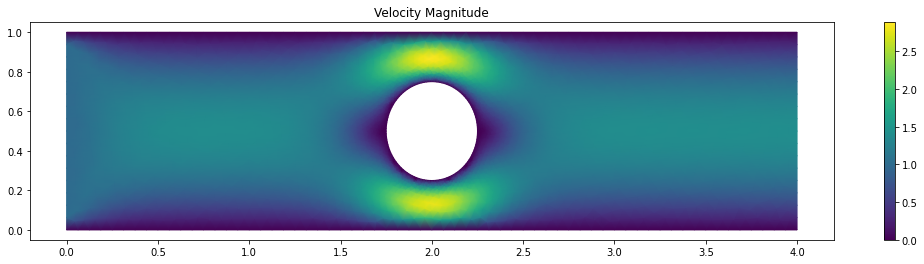

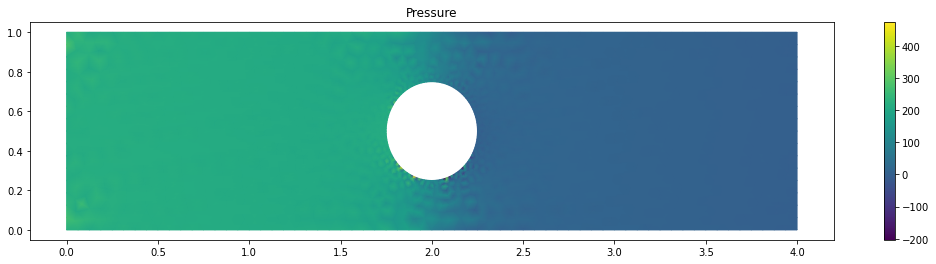

In [19]:
plt.figure(figsize=(18,4))
plot_soln(pts, tris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')

plt.figure(figsize=(18,4))
plot_soln(pts, tris, p)
plt.colorbar()
plt.title('Pressure')

Text(0.5, 1.0, 'Y Velocity')

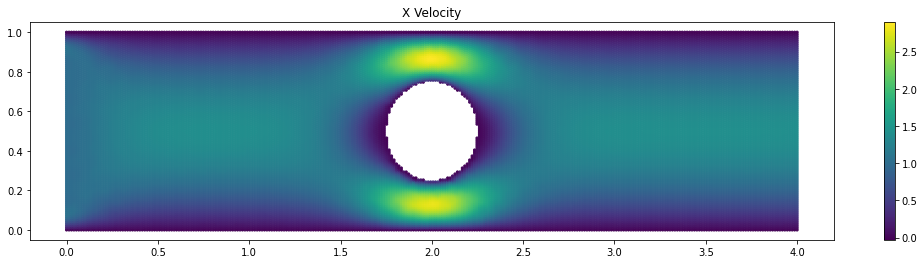

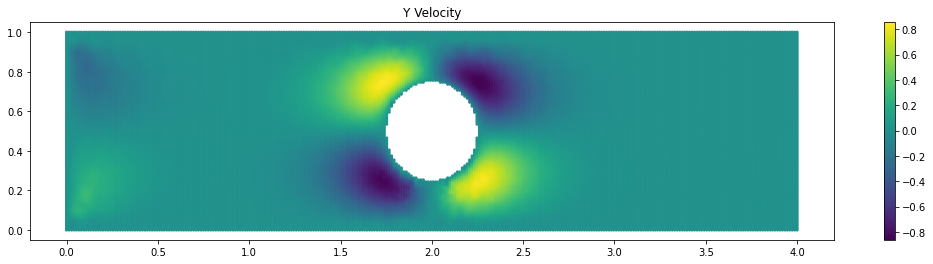

In [21]:
plt.figure(figsize=(18,4))
plot_soln_quad(pts, tris, u_x)
plt.colorbar()
plt.title('X Velocity')

plt.figure(figsize=(18,4))
plot_soln_quad(pts, tris, u_y)
plt.colorbar()
plt.title('Y Velocity')

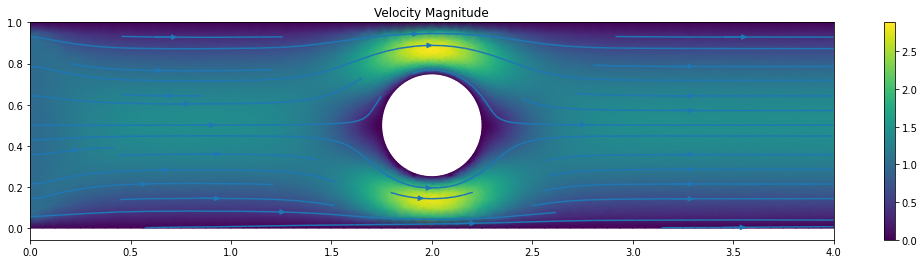

In [23]:
import matplotlib.tri as tri

def plot_streamlines(points, u_x, u_y):
    x = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 500)
    y = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 500)
    xx, yy = np.meshgrid(x,y);
    xi = np.row_stack([xx.flatten(),yy.flatten()])
    u_xi = si.griddata(points, u_x, xi.T, method='cubic')
    u_yi = si.griddata(points, u_y, xi.T, method='cubic')
    
    hole = ((xx-2)**2 + (yy-0.5)**2) <= (0.25)**2
    u_xi = u_xi.reshape(xx.shape)
    u_yi = u_yi.reshape(yy.shape)
    
    u_xi[hole] = 0
    u_yi[hole] = 0
    
    plt.streamplot(xx,yy,u_xi,u_yi,density=0.5)

plt.figure(figsize=(18,4))
plot_soln(pts, tris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')
plot_streamlines(pts, u_x, u_y)